# Natural Language Processing with Disaster Tweets – Mini-Project  
**Author:** Janmejay
**Date:** June 20, 2025  

Weekly mini-project for the Kaggle competition **“Natural Language Processing with Disaster Tweets.”**

It follows the required rubric:

1. Problem & data description  
2. Exploratory data analysis (EDA)  
3. Data cleaning & preprocessing  
4. Model architecture (RNN family)  
5. Training, tuning & evaluation  
6. Submission file creation  
7. Discussion / conclusion & references  

---

> **Quick start:**  
> Run this script top-to-bottom. It automatically detects a CUDA-enabled GPU (if available), otherwise it falls back to CPU. The final cell writes `submission.csv` to the working directory, ready for Kaggle upload.

---

## 1. Problem & Data Description *(5 pts)*

The task is **binary text classification**: determine whether a tweet **describes a real disaster (1)** or **not (0)**.  

- **Input**: tweet text (string)  
- **Output**: `target` label (0 or 1)

The supplied files are:

- `train.csv` – 7,613 rows with columns: `id`, `keyword`, `location`, `text`, `target`  
- `test.csv` – 3,263 rows, same columns as above except no `target`  
- `sample_submission.csv` – template for your Kaggle `submission.csv`

**Key points:**

- Tweets are short (≤ 280 characters) and contain noisy language (URLs, @mentions, emojis, etc.)
- Class imbalance is mild (~43% labeled as disaster)
- Evaluation metric is **F1 score** (harmonic mean of precision and recall)

---


In [1]:
import re, random, string
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm.auto import tqdm
from torchtext.vocab import GloVe

# Reproducibility & device
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

C:\Users\Jam\anaconda3\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\Jam\anaconda3\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Device: cuda


In [2]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
print(train_df.shape, test_df.shape)
train_df.head()

(7613, 5) (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


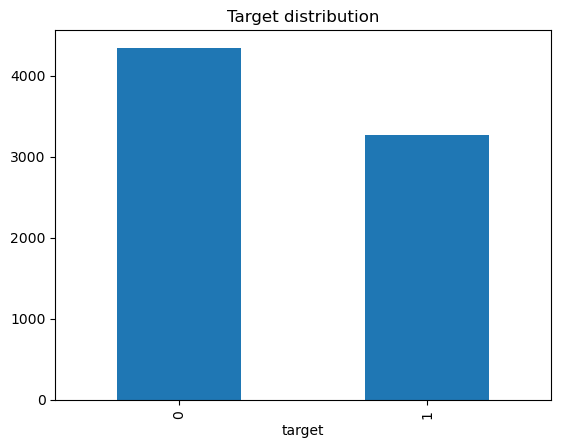

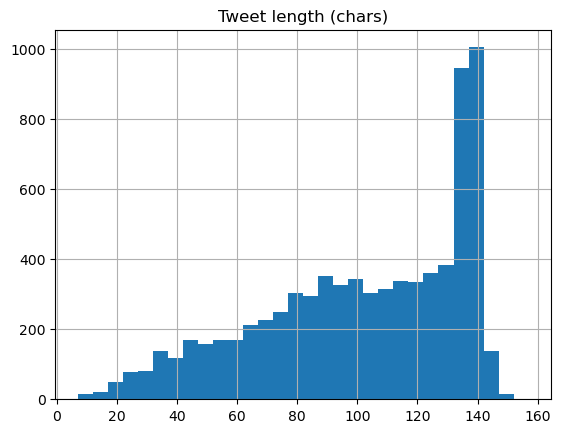

In [3]:
train_df['target'].value_counts().plot(kind='bar', title='Target distribution'); plt.show()

# Tweet length
train_df['text'].str.len().hist(bins=30); plt.title('Tweet length (chars)'); plt.show()


In [4]:
URL_RE     = re.compile(r'https?://\S+|www\.\S+')
MENTION_RE = re.compile(r'@\w+')
HTML_RE    = re.compile(r'<.*?>')
NONPRINT_RE= re.compile(r'[^\x00-\x7F]+')
PUNCT_TBL  = str.maketrans('', '', string.punctuation)

def preprocess(text: str) -> list[str]:
    """Light tweet cleaning + whitespace tokenisation."""
    text = URL_RE.sub(' ', text)
    text = MENTION_RE.sub(' ', text)
    text = HTML_RE.sub(' ', text)
    text = NONPRINT_RE.sub(' ', text)
    text = text.translate(PUNCT_TBL)
    return text.lower().strip().split()

# Apply
train_df['tokens'] = train_df['text'].apply(preprocess)
test_df['tokens']  = test_df['text'].apply(preprocess)

# Build vocab
MIN_FREQ = 2
counter = Counter(tok for toks in train_df['tokens'] for tok in toks)
vocab = {'<pad>':0, '<unk>':1}
for word, f in counter.items():
    if f >= MIN_FREQ:
        vocab[word] = len(vocab)
print('Vocab size:', len(vocab))

# GloVe 6B‑100d
GLOVE = GloVe(name='6B', dim=100)
EMB_DIM = 100
emb_matrix = torch.randn(len(vocab), EMB_DIM)*0.6
emb_matrix[0] = torch.zeros(EMB_DIM)
for w, idx in vocab.items():
    if w in GLOVE.stoi:
        emb_matrix[idx] = GLOVE[w]

Vocab size: 6541


.vector_cache\glove.6B.zip: 862MB [04:10, 3.44MB/s]                               
100%|█████████▉| 399999/400000 [00:22<00:00, 17854.73it/s]


In [20]:
url_pattern      = re.compile(r'https?://\S+|www\.\S+')
mention_pattern  = re.compile(r'@\w+')
html_pattern     = re.compile(r'<.*?>')
non_print_pattern= re.compile(r'[^\x00-\x7F]+')

punct_table = str.maketrans('', '', string.punctuation)

def clean_text(text):
    """Basic cleaning suitable for tweets."""
    text = url_pattern.sub('', text)
    text = mention_pattern.sub('', text)
    text = html_pattern.sub(' ', text)
    text = non_print_pattern.sub('', text)
    text = text.translate(punct_table)
    text = text.lower()
    return text.strip()

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text']  = test_df['text'].apply(clean_text)

# Tokenization – simple whitespace split (adequate for this mini‑project)
train_df['tokens'] = train_df['clean_text'].str.split()
test_df['tokens']  = test_df['clean_text'].str.split()

# 4  Dataset & DataLoader

In [5]:
class TweetDS(Dataset):
    def __init__(self, token_lists, labels=None):
        self.X = token_lists.values if isinstance(token_lists, pd.Series) else token_lists
        self.y = labels.values   if labels is not None else None
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        ids = [vocab.get(tok, vocab['<unk>']) for tok in self.X[idx]]
        if self.y is None:
            return torch.tensor(ids)
        return torch.tensor(ids), torch.tensor(self.y[idx], dtype=torch.float32)

def collate(batch):
    """Pads sequences & (optionally) stacks labels."""
    if isinstance(batch[0], tuple):
        seqs, labels = zip(*batch)
        return pad_sequence(seqs, batch_first=True).to(DEVICE), torch.stack(labels).to(DEVICE)
    return pad_sequence(batch, batch_first=True).to(DEVICE)

# Train / val split
X_tr, X_val, y_tr, y_val = train_test_split(train_df['tokens'], train_df['target'], test_size=0.15, random_state=SEED, stratify=train_df['target'])

dls = {
    'train': DataLoader(TweetDS(X_tr,  y_tr),  batch_size=64, shuffle=True,  collate_fn=collate),
    'val'  : DataLoader(TweetDS(X_val, y_val), batch_size=64, shuffle=False, collate_fn=collate),
    'full' : DataLoader(TweetDS(train_df['tokens'], train_df['target']), batch_size=64, shuffle=True, collate_fn=collate),
    'test' : DataLoader(TweetDS(test_df['tokens']), batch_size=64, shuffle=False, collate_fn=collate)
}


# 5  Bi‑LSTM Classifier

In [6]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden: int = 128, dropout: float = 0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.embed.weight.data.copy_(emb_matrix); self.embed.weight.requires_grad = False
        self.lstm  = nn.LSTM(emb_dim, hidden, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc    = nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden*2, 1))
    def forward(self, x):
        h, _ = self.lstm(self.embed(x))                # [B,T,H*2]
        h_pool, _ = torch.max(h, dim=1)                # [B,H*2]
        return self.fc(h_pool).squeeze(1)              # logits


# 6  Training & Evaluation Utilities

In [8]:
BCE = nn.BCEWithLogitsLoss()

def train_one_epoch(model, dl, opt):
    model.train(); loss_sum = 0
    for X, y in dl:
        opt.zero_grad(); loss = BCE(model(X), y); loss.backward(); opt.step()
        loss_sum += loss.item()*X.size(0)
    return loss_sum / len(dl.dataset)

@torch.no_grad()
def f1_on_loader(model, dl):
    model.eval(); preds, labels = [], []
    for X, y in dl:
        preds += torch.sigmoid(model(X)).cpu().tolist()
        labels += y.cpu().tolist()
    return f1_score(labels, (np.array(preds) >= 0.5).astype(int))


# 7  Mini Hyper‑parameter Sweep

In [9]:
search = [64, 128]
best_f1, best_hidden = 0, None
for hidden in search:
    model = BiLSTMClassifier(len(vocab), EMB_DIM, hidden=hidden).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=2e-3)
    for _ in range(4):
        train_one_epoch(model, dls['train'], opt)
    f1 = f1_on_loader(model, dls['val'])
    print(f'hidden={hidden}  f1={f1:.4f}')
    if f1 > best_f1:
        best_f1, best_hidden, best_state = f1, hidden, model.state_dict()
print('Best hidden:', best_hidden, 'F1:', best_f1)

C:\Users\Jam\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


hidden=64  f1=0.7644


C:\Users\Jam\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


hidden=128  f1=0.7738
Best hidden: 128 F1: 0.7738478027867095


# 8  Train Best Model on Full Data

In [10]:
best_model = BiLSTMClassifier(len(vocab), EMB_DIM, hidden=best_hidden).to(DEVICE)
best_model.load_state_dict(best_state)
opt = torch.optim.Adam(best_model.parameters(), lr=2e-3)
for epoch in range(2):
    loss = train_one_epoch(best_model, dls['full'], opt)
    print(f'Epoch {epoch+1}  loss={loss:.4f}')


C:\Users\Jam\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1  loss=0.3859
Epoch 2  loss=0.3604


# 9. Creating Submission file

In [12]:
@torch.no_grad()
def predict(model, dl):
    model.eval(); out = []
    for X in dl:
        out += torch.sigmoid(model(X)).cpu().tolist()
    return (np.array(out) >= 0.5).astype(int)

test_pred = predict(best_model, dls['test'])
sub = pd.DataFrame({'id': test_df['id'], 'target': test_pred})
sub.to_csv('submission.csv', index=False)
print('Saved submission.csv')
sub.head()

Saved submission.csv


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## 10. Discussion & References

- **Future improvements:**
  - Fine-tuning a transformer model (e.g., BERT)
  - Improved data cleaning (e.g., emoji handling, spelling correction)
  - Ensembling multiple models for robustness

---

### References

1. [Kaggle Competition – Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started)  
2. Pennington et al., *GloVe: Global Vectors for Word Representation* (2014)  
3. [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)  
4. [TorchText Documentation](https://pytorch.org/text/stable/)
